In [1]:
try:
    %load_ext autoreload
    %autoreload 2
except:
        pass
%matplotlib inline
import functions.add_path

import functions.plotnine_theme
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *
import os
print(os.getcwd())
if os.getcwd()[-4:] != 'code':
    try:
        os.chdir('./code')
    except:
        os.chdir('/net/store/nbp/users/behinger/projects/etcomp/code')

import av # import to import before any pupillabs libraries

/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5

/net/store/nbp/users/behinger/projects/etcomp/code


In [2]:
from lib.pupil.pupil_src.shared_modules import file_methods as pl_file_methods

In [3]:
from functions import et_import
#from  functions.nbp_recalib import sort_pupil

In [4]:
import pl_anna_tools
import av
# Pretty serious workaround. Ignores errors in imports :S
import builtins
from types import ModuleType

class DummyModule(ModuleType):
    def __getattr__(self, key):
        return None
    __all__ = []   # support wildcard imports

def tryimport(name, *args, **kwargs):
    try:
        imp = realimport(name, *args,**kwargs)
        #print('success: '+name)
        return imp 
    except Exception as e:
        print('reached exception:' + name)
        if name =='cPickle': # because how they import cPickle/Pickle
            return realimport('pickle', *args,**kwargs)    
        
        #print(e)
        return DummyModule(name)



realimport, builtins.__import__ = builtins.__import__, tryimport
try:
    import lib.pupil.pupil_src.shared_modules.calibration_routines.manual_marker_calibration as mc

except Exception as e:
    print('-------------------')
    print(e)
    pass
tryimport, builtins.__import__ = builtins.__import__, realimport

reached exception:OpenGL_accelerate
reached exception:OpenGL.acceleratesupport
reached exception:OpenGL.error
reached exception:OpenGL.GL
reached exception:OpenGL_accelerate
reached exception:OpenGL.acceleratesupport
reached exception:OpenGL.error
reached exception:OpenGL_accelerate
reached exception:OpenGL.acceleratesupport
reached exception:OpenGL.arrays.arraydatatype
reached exception:OpenGL_accelerate
reached exception:OpenGL.acceleratesupport
reached exception:OpenGL.error
reached exception:OpenGL_accelerate
reached exception:OpenGL.acceleratesupport
reached exception:OpenGL.converters
reached exception:OpenGL.arrays.arrayhelpers
reached exception:OpenGL_accelerate
reached exception:OpenGL.acceleratesupport
reached exception:OpenGL.error
reached exception:OpenGL.wrapper
reached exception:OpenGL.raw.GLU
reached exception:OpenGL_accelerate
reached exception:OpenGL.acceleratesupport
reached exception:OpenGL.error
reached exception:OpenGL.wrapper
reached exception:OpenGL.raw.GLU
reach

In [5]:
from functions.et_helper import tic,toc


In [8]:
cap = pl_anna_tools.init_playback(video_name = 'world.mp4',video_file_path = '/net/store/nbp/projects/IntoTheWild/Daten/Eyetracking/Wild/VP21/2018_05_24/001')

In [28]:
pupil_data = pl_file_methods.load_object(os.path.join(video_file_path,'pupil_data'))

In [12]:
#pupil_data2 = pl_file_methods.load_object('/net/store/nbp/projects/IntoTheWild/Daten/Eyetracking/Wild/VP21/2018_05_24/001/offline_data/offline_pupil.pldata')

pupil_data2 = pl_file_methods.load_pldata_file(directory='/net/store/nbp/projects/IntoTheWild/Daten/Eyetracking/Wild/VP21/2018_05_24/001/offline_data/',topic='offline_pupil')

In [29]:
pupil_data['pupil_position'] = pupil_data2.data

In [30]:
world_timestamps= np.load(os.path.join(video_file_path,'world_timestamps.npy'))

In [31]:

ind = np.digitize([p['timestamp'] for p in pupil_data['pupil_positions']],world_timestamps)-1


In [32]:
calib = mc.Manual_Marker_Calibration(Global_Container)

In [33]:
# we cant use the calib.start() because of the super-inherited function that wants to update the gui
import types
calib.active = True
calib.ref_list = []
calib.pupil_list = []
calib.button = Global_Container()
calib.g_pool.get_timestamp = lambda:None
calib.trackerid = 0
def notify_capture_complete(self,x):
    if x['subject'] == 'calibration.marker_sample_completed':
        self.trackerid +=1
        print(self.trackerid)
        for i,r in enumerate(self.ref_list):
            if 'trackerid' not in r.keys():
                r['trackerid'] = self.trackerid
            self.ref_list[i] = r
            
        
calib.notify_all =  types.MethodType(notify_capture_complete,calib)

In [35]:
calibrange = range(29724,37479)
calib.circle_tracker._wait_count = 0
tic()
for k in calibrange:
    if np.mod(k-min(calibrange),500) == 0:
        print('Progress: %.1f%%'%((float(k-min(calibrange))/(max(calibrange)-min(calibrange)))*100))
        
    cap.seek_to_frame(k)
    
    frame= cap.get_frame()
    
    pupil_idx = np.where(ind == cap.get_frame_index())[0]
    pupil_in_bound = [pupil_data['pupil_positions'][i] for i in pupil_idx]
    
    # look at the current frame
    # pupil_position for pupil <v1.8 , pupil for pupil >=v1.8
    calib.recent_events({'frame':frame,'pupil':pupil_in_bound,'pupil_position':pupil_in_bound})
    #if calib.sample_ref_dist >0.1:
    #    print('marker found: %i, smooth_vel:%.3f, sample_ref_dist:%.3f'%(len(calib.markers),calib.smooth_vel,calib.sample_ref_dist))
toc()

Progress: 0.0%
Progress: 6.4%
Progress: 12.9%
Progress: 19.3%
Progress: 25.8%
1
2
Progress: 32.2%
3
4
Progress: 38.7%
5
6
Progress: 45.1%
7
Progress: 51.6%
8
9
Progress: 58.0%
10
11
Progress: 64.5%
12
Progress: 70.9%
13
Progress: 77.4%
Progress: 83.8%


Marker moved too quickly: Aborted sample. Sampled 20 datapoints. Looking for steady marker again.


14
Progress: 90.3%
Progress: 96.7%
Elapsed time: 62.577424 seconds.



In [36]:
trackerids = [r['trackerid'] for r in calib.ref_list]

In [26]:
# for jedes trackerid timestamp set, find pupil positions that fall into that set

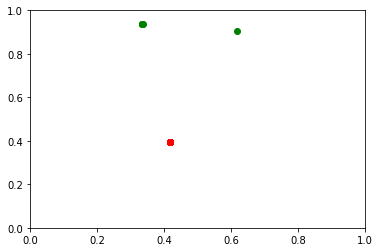

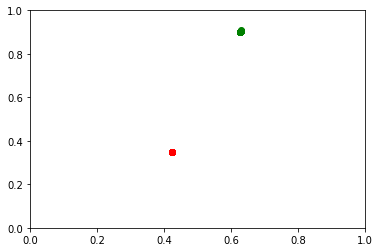

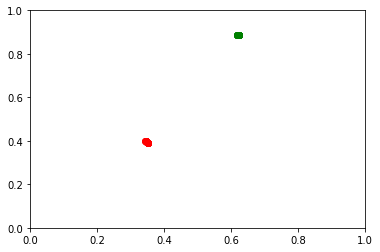

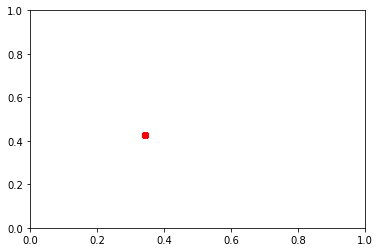

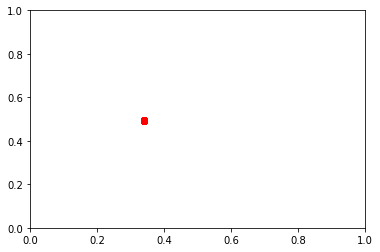

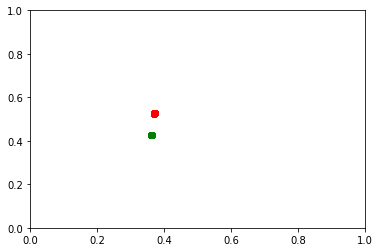

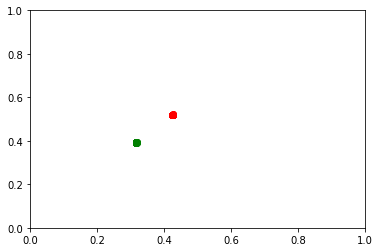

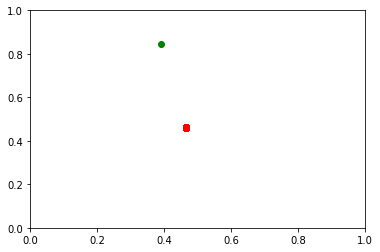

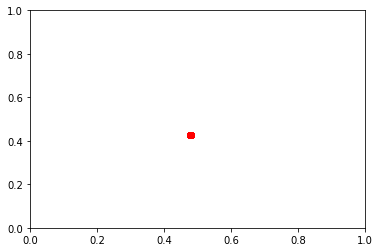

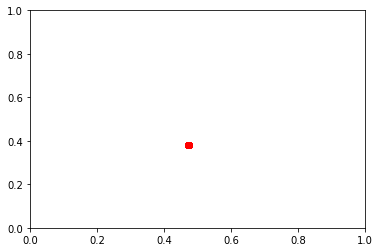

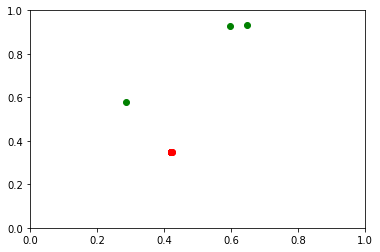

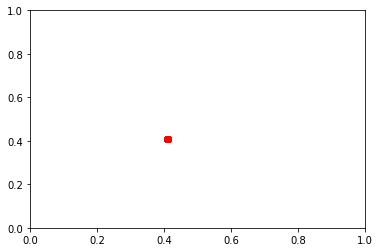

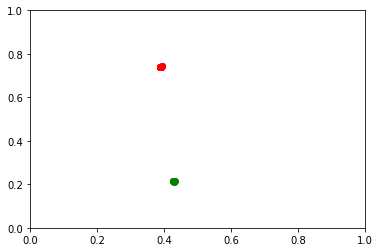

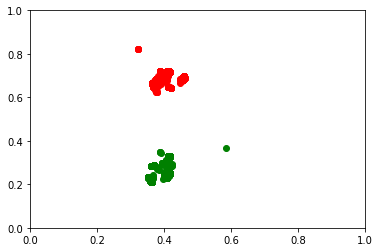

In [39]:
from functions.et_helper import mad
pupil_ts = np.array([c['timestamp'] for c in calib.pupil_list])
ref_pupil_spread = pd.DataFrame(columns=['trackerid','mad'])
for ref_id in np.unique(trackerids):
    ref_ts = [r['timestamp'] for r in calib.ref_list if r['trackerid']==ref_id]
    ref_ts_min,ref_ts_max = min(ref_ts),max(ref_ts)
    ix = np.where((pupil_ts>ref_ts_min) & (pupil_ts<=ref_ts_max))[0]
    pos2d_1 = np.array([calib.pupil_list[i]['norm_pos'] for i in ix if calib.pupil_list[i]['id']==0 and calib.pupil_list[i]['confidence']>0.8])
    pos2d_2 = np.array([calib.pupil_list[i]['norm_pos'] for i in ix if calib.pupil_list[i]['id']==1 and calib.pupil_list[i]['confidence']>0.8])
    plt.figure()
    
    if pos2d_1.size>0:
    
        plt.plot(pos2d_1[:,0],pos2d_1[:,1],'or')
    if pos2d_2.size>0:
        plt.plot(pos2d_2[:,0],pos2d_2[:,1],'og')
    plt.xlim([0,1])
    plt.ylim([0,1])


    m = np.mean(np.array([calib.pupil_list[i]['norm_pos'] for i in ix]),axis=0)
    #sd2d = np.mean(np.sqrt(np.square(pos2d[:,0]-m[0]) + np.square(pos2d[:,1]-m[1])))
    
    #ref_pupil_spread = ref_pupil_spread.append(pd.DataFrame([[ref_id,sd2d]],columns=['trackerid','mad']))

In [84]:
ref_pupil_spread

,trackerid,mad
0,1,0.284530
0,2,0.282250
0,3,0.267745
0,4,0.287005
0,5,0.048690
0,6,0.079989
0,7,0.236179
0,8,0.306719
0,9,0.354410
0,10,0.298224


In [64]:
pos2d = np.array([calib.pupil_list[i]['norm_pos'] for i in ix])

m = np.mean(np.array([calib.pupil_list[i]['norm_pos'] for i in ix]),axis=0)
mad2d = np.mean(np.sqrt(np.square(pos2d[:,0]-m[0]) + np.square(pos2d[:,1]-m[1])))

In [35]:
ref_x = [p['norm_pos'][0] for p in calib.ref_list]
ref_y = [p['norm_pos'][1] for p in calib.ref_list]
pup_x = [p['norm_pos'][0] for p in calib.pupil_list]
pup_y = [p['norm_pos'][1] for p in calib.pupil_list]

In [26]:
%matplotlib inline

In [39]:
#plt.plot(np.array(pup_x),np.array(pup_y),'ob')
plt.plot(ref_x,ref_y,'sr')
plt.xlim([0,1])
plt.ylim([0,1])

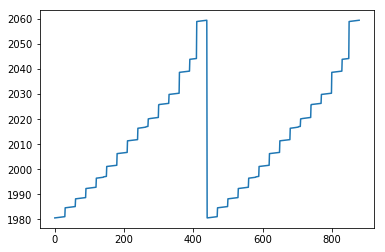

In [40]:
plt.figure
plt.plot([p['timestamp'] for p in calib.ref_list])

In [55]:
640/frame.gray.shape[0]

0.8888888888888888

In [43]:
calib.markers

[]

In [50]:
import lib.pupil.pupil_src.shared_modules.circle_detector as cd

In [57]:
cd.find_pupil_circle_marker(frame.gray,0.5)

[{'ellipses': [((545.5, 474.5), (3.7134180068969727, 3.7134180068969727), 0.0),
   ((545.4253416061401, 474.52602100372314),
    (11.08390998840332, 11.524243354797363),
    61.916175842285156),
   ((545.5, 474.6117887496948),
    (15.181777000427246, 15.617850303649902),
    90.0)],
  'marker_type': 'Ref'}]